# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [2]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
# Actualizar los datos (URL)
url = 'https://raw.githubusercontent.com/edison123344/Simulacion/main/new_cases.csv?token=AK2T4JLW4SIQBGJG4GO2NKS7WGRXI'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2020-11-04,505011,86.0,381.0,405.0,22.0,193.0,0.0,2.0,12145.0,...,299.0,NaN,0.0,395.0,11.0,0.0,0.0,4.0,118.0,21.0
310,2020-11-05,569778,121.0,396.0,548.0,135.0,349.0,0.0,0.0,10652.0,...,226.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,37.0,17.0
311,2020-11-06,612421,40.0,421.0,642.0,90.0,236.0,0.0,0.0,11100.0,...,360.0,NaN,0.0,821.0,0.0,0.0,0.0,0.0,72.0,17.0
312,2020-11-07,605995,58.0,489.0,631.0,0.0,289.0,0.0,0.0,11786.0,...,0.0,NaN,0.0,384.0,6.0,0.0,0.0,3.0,49.0,27.0


Imprimos los resultados y agregamos el numero del dia


In [14]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
309,308,548.0
310,309,1323.0
311,310,350.0
312,311,725.0


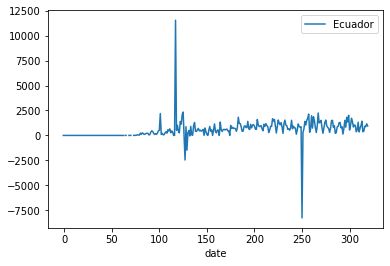

In [5]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [15]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)


660.5
699.5403225806451


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [16]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

180287


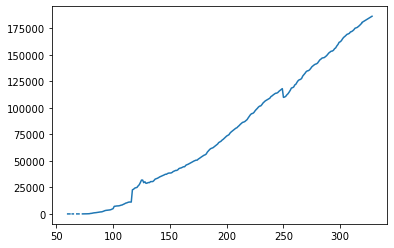

In [17]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.

### Modelos Matemáticos:
Un modelo es una descripción más o menos detallada de un fenómeno que se desea investigar. En donde el modelo matemático es aquel donde las entidades del sistema y sus atributos se representan o describen mediante variables matemáticas y usa el lenguaje matemático en su descripción. Ejemplo de modelo
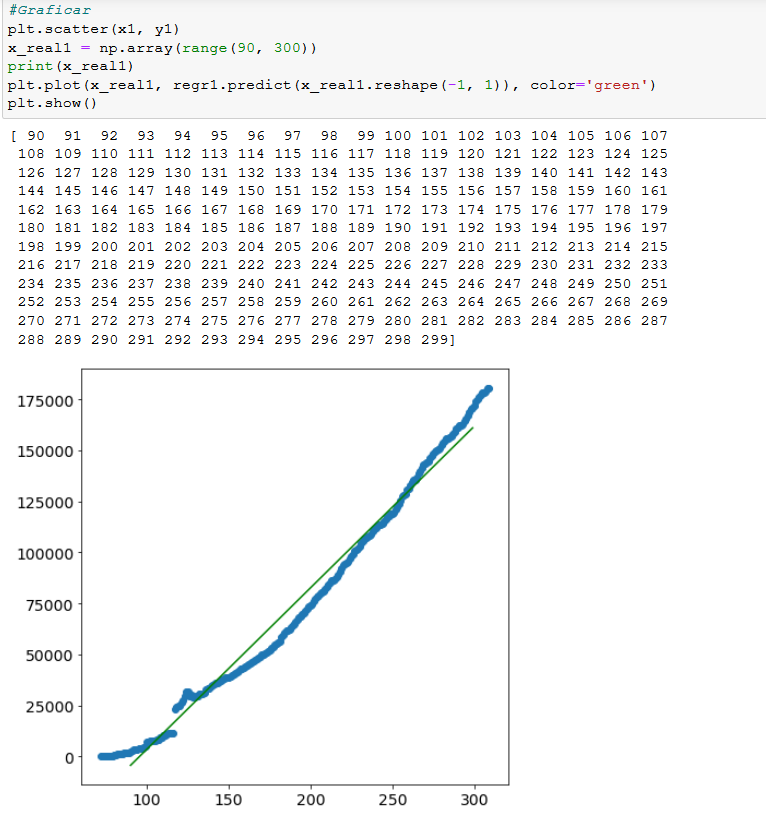

### Modelos Probabilísticos: 
Son aquellos que se basan en la estadística y probabilidades y incorporan incertidumbres que por lo general acompañan las observaciones de eventos reales. Esto permite generar predicciones para el valor esperado o para un valor individual de la variable dependiente (Y) asociado a un valor dado de la variable independiente (X). En ambos casos la predicción puntual es la misma y se obtiene sustituyendo en el modelo estimado el valor X0 para el cual se desea realizar la predicción. Ejemplo de modelo: 
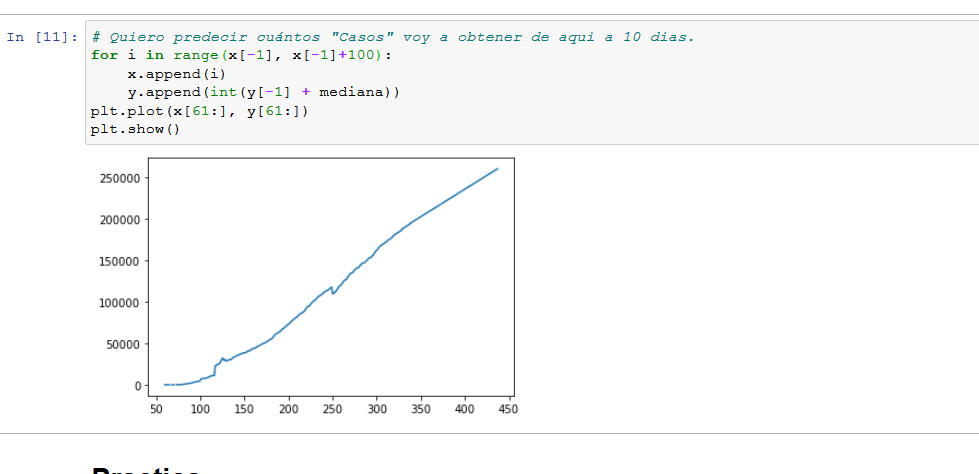

2. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.


### datos reales de ase 7 dias 
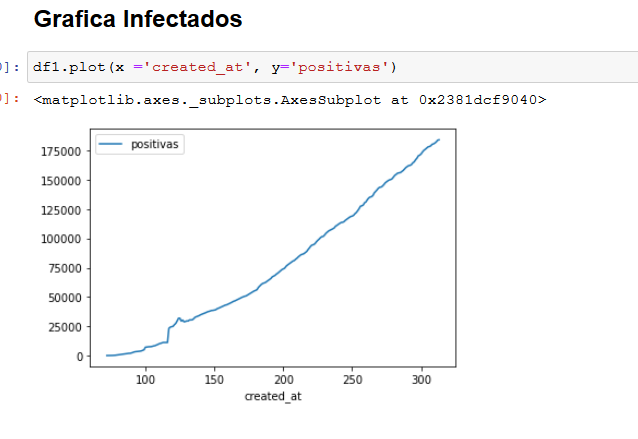
### Datos actuales
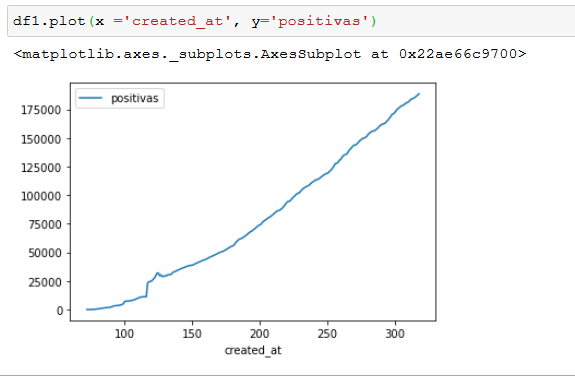
### modelo polinomial ase 7 dias
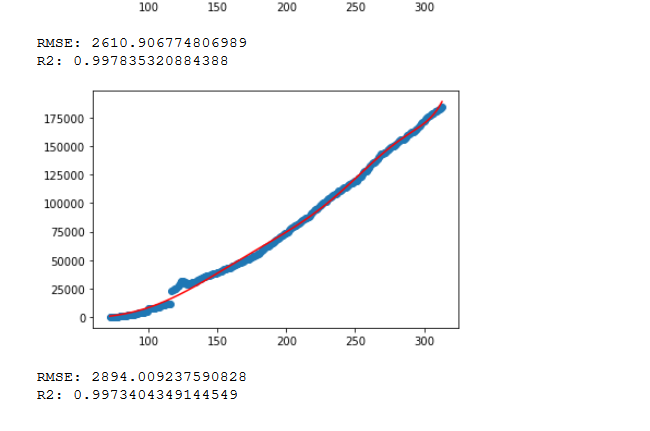
### modelo actual
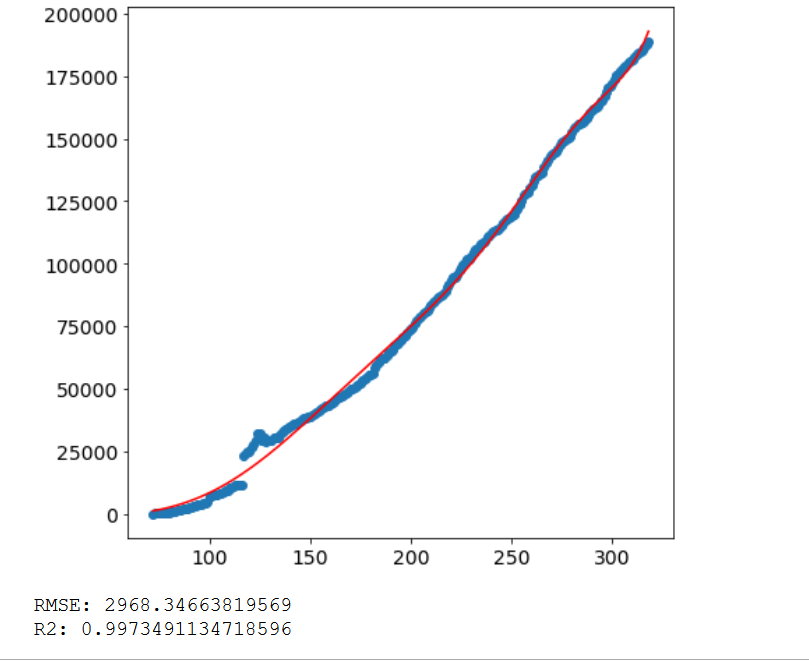

### modelo probabilistico ase 7dias
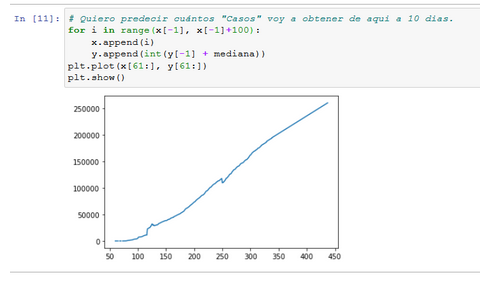
### modelo actual
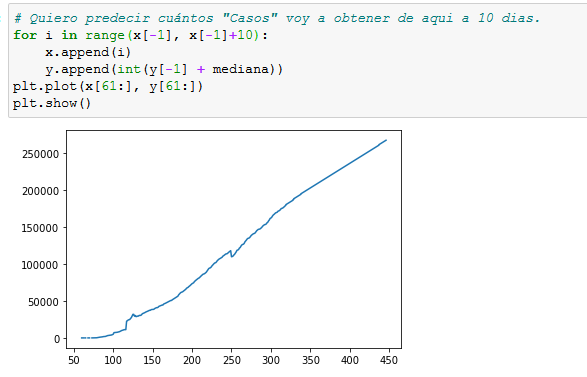

### conclucion
es escaso se puede ver que es estos 7 dias a avido un sierto incremento en la tasa de unfectados ademas de de maos trar que los modelos que mas se agjustaron ala situacion actual son el modelo probalistico y el modelo polinomial por parte de el modelo matematico


## Analisis
se a prosedido a analisar los modelos  matematicos y probabilisticos y se a concluido que cada modelo tiene siertas caracteristicas y usos bariados por ejemplo el modelo de probabilida busca mediante prediccion predisir cual sera la tendencia del virus a futuro mi entras que un modelo matematico tiende a ser un linea qeu vusca adamtarse ala informasion 

## Conclusiones
se pude concluir que los modelos probabilisticos puede  realisar una estimacion mas fiel ala realidad en el caso del covid

## Criterio personal (politico, economico y  social de la situacion)
se puede concluir que la taza de cresimiento de cada uno de estos modelos demuestra un grabe problema el cual es el que  la enfermedad se a descontrolado y puede causar problemas alos establesimientos de salud del pais ademas causar problemas a personas que acuden al hospital por problemas distintos al COVID



# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/

- https://www.abc.es/ciencia/abci-modelos-matematicos-pueden-realmente-predecir-futuro-202010250143_noticia.html

- https://www.revespcardiol.org/es-medidas-del-rendimiento-modelos-prediccion-articulo-S0300893211004830